## 1. Tutorial: Introduction to the SIR Model and the Workbench
Learn the basics of the SIR model, connect it to the workbench, run simulations, and visualize the results to understand the impact of uncertain parameters.

### Overview of this notebook
- Introduction to the SIR model:
  - Learn the basic principles of the SIR model for disease spread.
  - Understand the three groups in the model and the role of parameters β and γ.
- Connecting the SIR model with the workbench:
  - Learn how to connect a Python-based model to the workbench.
  - Understand how to specify uncertain parameters and outcomes of interest.
- Running the model with the workbench:
  - Learn how to run the connected model using the workbench's evaluator and perform_experiments method.
  - Explore the concept of scenarios and the default sampling method used by the workbench.
- Visualizing the results:
  - Get introduced to visualization tools provided by the workbench for time series data.
  - Investigate the effects of uncertain parameters on the outcomes and gain insights from the visualizations.

### SIR model
A very basic model for the spread of a dissease is the Succeptible, Infected, Recovered (SIR) model. This model splits a population into three groups.

1. $S(t)$ - the part of the population that is succeptible but not yet infected with the disease
2. $I(t)$ - the part of the population that is infected with the disease
3. $R(t)$ - the part of the population that has recovered from the disease. 

The SIR model uses a system of ODE's to describe how these three groups change over time. In it's most simple form, the model uses only the contact ration $\beta$ and the mean recovery rate $\gamma$ for this.

Below is a python implementation of this simple model, taken from https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/. 


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint

In [11]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def SIR_model(beta=0.2, gamma=0.1, I0=1, R0=0, 
              N=1000, t=np.linspace(0, 160, 160)):
    '''
    
    Parameters
    ----------
    beta : float
           contact rate
    gamma : float
            recovery rate
    I0 : int
         initial value infected
    R0 : int
         initial value recovered
    N : int
        population size
    t : ndarray
        points in time
    
    '''
    S0 = N - I0 - R0
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    return {'S':S, 'I':I, 'R':R}

### Connecting the SIR model with the workbench

Let's connect this simple model to the workbench. We make the following assumptions
1. $\beta$ and $\gamma$ are uncertain. We assume that $\beta$ is somewhere between 0.05 and 0.3, while $\gamma$ is somewhere between 0.01, and 0.15.
2. The outcomes of interest are $S(t)$, $I(t)$, and $R(t)$ over time.

To connect the model to the workbench, we need to do at least 3 things:
1. **Instantiate a model class**; the workbench comes with a variety of model classes for making it easy to connect with existing simulation packages such as Vensim, PySD, Simio, or Netlogo. Since we have a model implemented in Python, we can use the most basic Model class.
2. **Specify the uncertain parameters** (and/or decision levers); Note below how the name of the parameters matched the name of the keyword arguments of the SIR_model function. The workbench makes a distinction between RealParameters, IntegerParameters, BinaryParameters, and CategoricalParameters. For this example, our parameters $\beta$ and $\gamma$ have a continuous range so we use RealParameters 
3. **Specify the outcomes of interest**; the workbench makes a distinction between TimeSeriesOutcomes and ScalarOutcomes. $S$, $I$, and $R$ are time series, so we use TimeSeriesOutcomes

In [15]:
from ema_workbench import Model, RealParameter, TimeSeriesOutcome

model = Model('SIR', function=SIR_model)

model.uncertainties = [RealParameter('beta', 0.05, 0.3),
                       RealParameter('gamma', 0.01, 0.15)]

model.outcomes = [TimeSeriesOutcome('S'),
                  TimeSeriesOutcome('I'),
                  TimeSeriesOutcome('R')]

The code above is a minimum working example of how to connect a model, the SIR_model function in this case, to the ema workbech. Even very large and complex cases will mimic this structure. 

### Running the model with the workbench

The next step is to run the model. For this we use an evaluator and the perform_experiments method. The workbench by default will use a latin hypercupe sampler to generate points in the parameter space defined by the uncertainties and/or levers. The uncertainties jointly span the uncertainty space. The levers (not used in this example) span the lever space. A point in uncertainty space is a scenario. A point in lever space is a policy. The combination of a scenario and a policy (where either might be None) is an experiment. 

A few remarks on this
1. The workbench assumes uniform distributions. During the class it will be explained in more detail why we make this assumption and what consequences follow from this.
2. The workbench comes with a wide range of alternative samplers, some of which we will use later in the course
3. The workbench offers support for taking advantage of the fact that many modern computers have multiple cores. See assingment 2 for this week for more on this. For now, we use a SequentialEvaluator
4. The workbench treats sampling in the uncertainty space and the lever space separately. It will always execute a full factorial over the combination of the lever space and the uncertainty space.

Let's run the model for 100 scenarios.

In [16]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 441.31it/s]


In [32]:
experiments

,beta,gamma,scenario,policy,model
0,0.093125,0.085214,300,None,SIR
1,0.217548,0.116700,301,None,SIR
2,0.281737,0.038243,302,None,SIR
3,0.267486,0.049793,303,None,SIR
4,0.124190,0.131679,304,None,SIR
...,...,...,...,...,...
95,0.285943,0.143307,395,None,SIR
96,0.074859,0.145905,396,None,SIR
97,0.178228,0.070165,397,None,SIR
98,0.235915,0.128561,398,None,SIR


### Visualizing the results

Now that we have run the model 100 times, we can visualize the results. The workbench comes with a range of analysis functions including some convenience functions for visualizing time series data. For now, we use the function `ema_workbench.analysis.plotting.lines`. If you want to get a sense of what other analyses are available, please read the online documentation at https://emaworkbench.readthedocs.io. Over the coming weeks, we will systematically go through many of the analyses that are available.

C:\Users\Shahram\PyCharm\Model-Based Decision Making\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


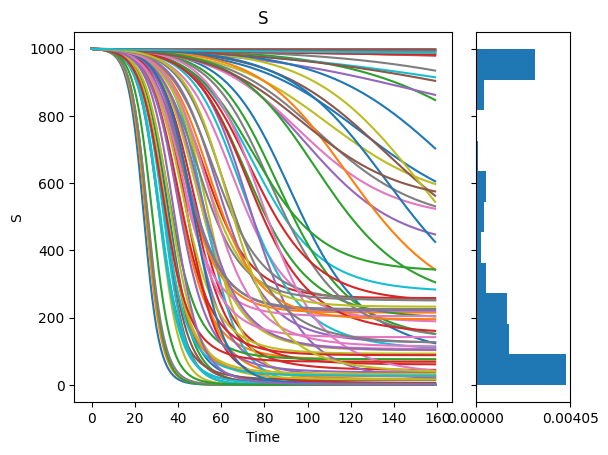

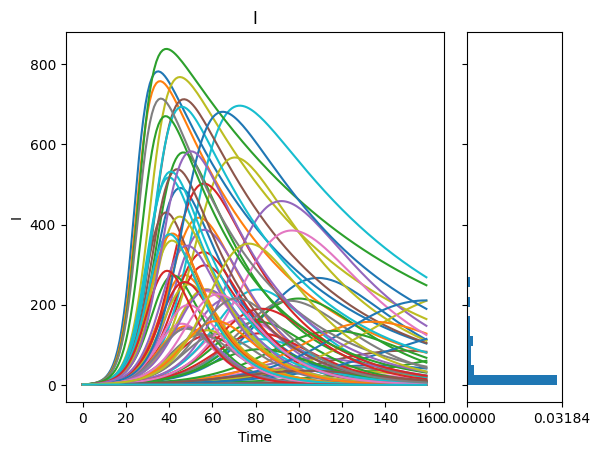

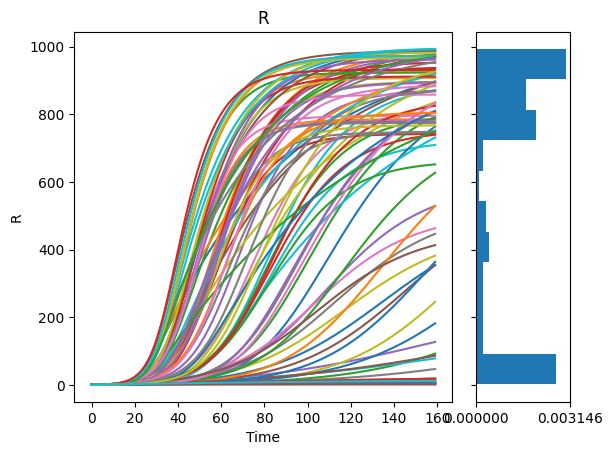

In [17]:
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome,
                   density=plotting_util.Density.HIST)
plt.show()

In each plot on the left for all hunderd runs the susceptible, infected, and recovered population are plotted. On the right of each plot, a histogram of these values is shown.

#### Effect uncertainty on outbreak
A key element in exploratory modeling is to try to understand how points in the uncertainty space map relate to outcomes or types of outcomes. Since in this example, we only have 2 uncertain parameters, basic visual inspection can already give a fair bit of insight. Let's try to answer the following question: how do $\gamma$ and $\beta$ affect the severity and timing of the outbreak? To answer this we need to do the following:
1. get the maximum value over time for $I$ for each scenario (use np.max)
2. Establish the point in time of this maximum (use np.argmax)
3. visualize how 1 and 2 are affected by $\beta$ and $\gamma$ **jointly** (use scatter plots with max I, and the point in time as color)
4. How are timing and the maximum related to each other?


In [11]:
# Calculate the maximum value of I
I = outcomes['I']
maxI = np.max(I, axis=1)

# Calculate the timing of the maximum value of I
timing = np.argmax(I, axis=1)

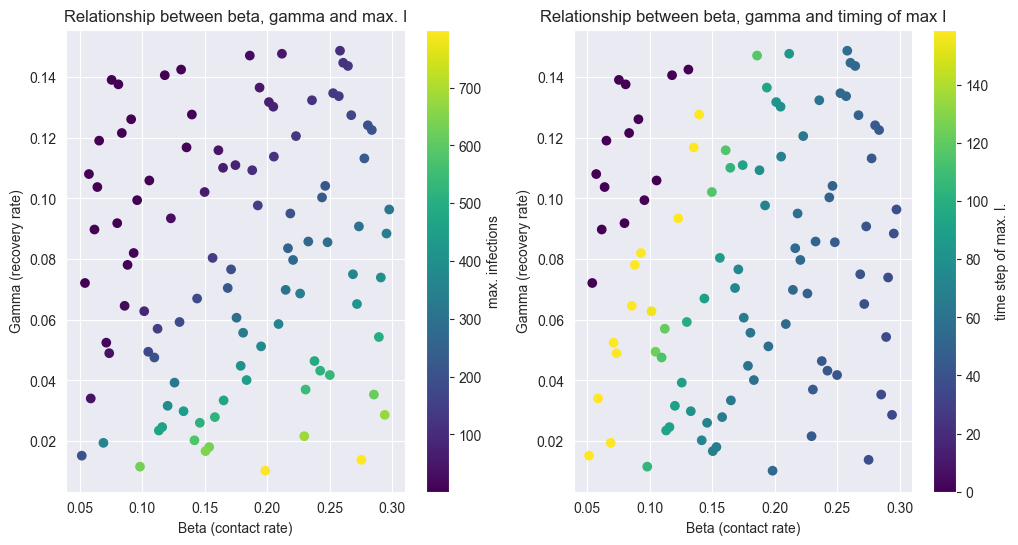

In [40]:
def plot_scatter(labels=False, beta_is_gamma_line=False):
    # Plot the relationship between beta and gamma, using max I and timing as color
    fig, ax = plt.subplots(1,2, figsize=(12,6))

    for i, hue in enumerate([maxI, timing]):
        sc = ax[i].scatter(experiments.beta, experiments.gamma, c=hue, cmap='viridis')
        cb = plt.colorbar(sc)
        ax[i].set_title(f"Relationship between beta, gamma and {['max. I', 'timing of max I'][i]}")
        ax[i].set_xlabel('Beta (contact rate)')
        ax[i].set_ylabel('Gamma (recovery rate)')
        cb.set_label(['max. infections', 'time step of max. I.'][i])

        # Add labels with the hue value
        if labels:
            for j, (beta, gamma) in enumerate(zip(experiments.beta, experiments.gamma)):
                ax[i].text(beta, gamma, f"{hue[j]:.0f}", fontsize=8)

        # To the second plot, add a line with beta = gamma
        if i == 1 and beta_is_gamma_line:
            ax[i].plot(np.linspace(0.05,0.15), np.linspace(0.05,0.15), color='red')
    plt.show()

plot_scatter()

Notable on the left plot is that a higher beta value and a lower gamma value are associated with a higher maximum value of I. This is intuitive, since a higher beta values means more contact between individuals, and a lower gamma value means that individuals are less likely to recover.

On the right plot, there is more interesting behaviour. With a low contact rate and high recovery rate, the highest number of infected people is at the first time step. Only the initially infected person is infected, and infects no other persons. After that, as the contact rate increases and recovery rate decreases, the time of the maximum value of I shifts from the last time step (meaning likely no peak is reached during the simulation) to shorter and shorter time steps.

This becomes even clearer if we add labels with the numbers, and a red line with beta = gamma to the second plot. If the recovery rate is higher than the infection rate, the disease will likely die out.



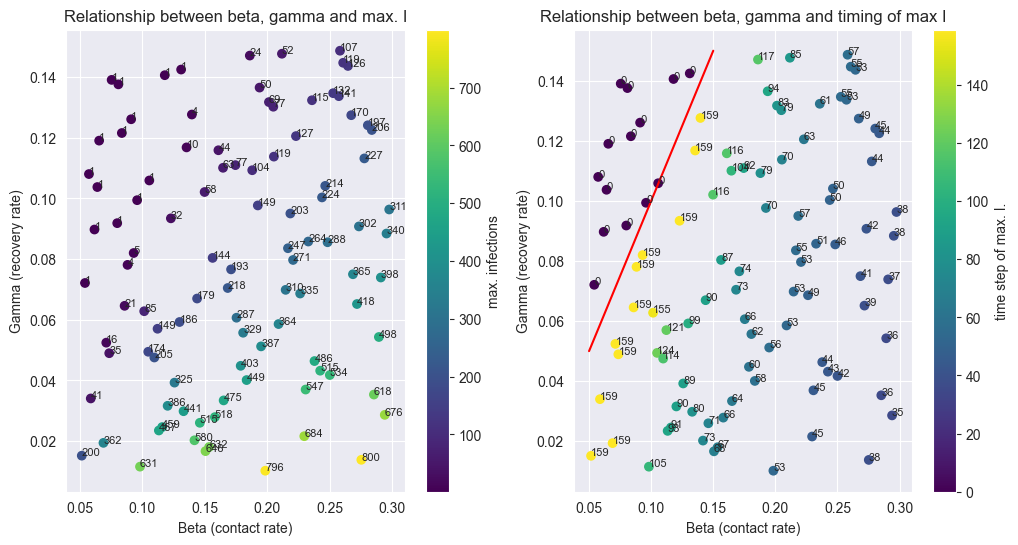

In [41]:
plot_scatter(labels=True, beta_is_gamma_line=True)

Finally, if we want to see how the timing and the maximum value of I are related to each other, we can use a scatter plot with the timing on the x-axis and the maximum value of I on the y-axis.

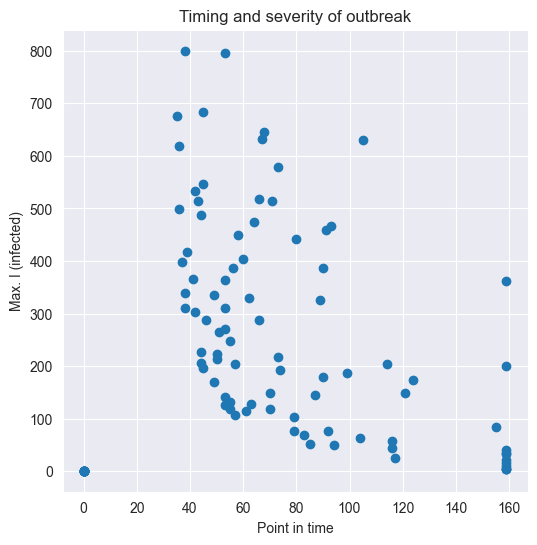

In [48]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(timing, maxI)
ax.set_title('Timing and severity of outbreak')
ax.set_xlabel('Point in time')
ax.set_ylabel('Max. I (infected)')
plt.show()

Notably, there is a negative correlation between the timing of the outbreak and the number infected. A slow outbreak with a late peak has a low number of infected people, while a fast outbreak with an early peak has a high number of infected people. This is intuitive, since a slow outbreak has more time to spread, and a fast outbreak has less time to spread.

### Conclusion
This shows an example of how to use the workbench to explore a simple model, and how to use the workbench to visualize and interpret the results.

Assignment 2 and 3 will introduce two other models, which you will be able to explore yourself using the workbench.

The [EMAworkbench documentation](https://emaworkbench.readthedocs.io/en/latest/) and [code itself](https://github.com/quaquel/EMAworkbench) provide a lot of information on how to use the workbench, as well as a lot of [examples](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples).